# Sapheneia TimesFM

This notebook mirrors the webapp functionality exactly, using the same `/src` code.
Run cells sequentially to replicate the complete webapp workflow.

## Features:
- Model initialization
- Data upload and processing
- Forecasting with quantiles
- Dynamic quantile band visualization
- Data export

## Prerequisites:
```bash
source .venv/bin/activate
```


## 1. Setup and Imports

Import the same modules used by the webapp.


In [1]:
# Configure notebook environment

import warnings
warnings.filterwarnings('ignore')

import sys
import os
import json
import logging
from datetime import datetime

# Add src to path for imports (same as webapp)
sys.path.append('../src')

# Core imports (same as webapp)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sapheneia TimesFM imports (same as webapp)
from model import TimesFMModel
from data import DataProcessor
from forecast import Forecaster
from visualization import Visualizer

# Configure logging (same as webapp)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("🚀 Sapheneia TimesFM Webapp Mirror Ready!")
print(f"📅 Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("📁 Using /src modules directly (same as webapp)")


 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.12 (main, Apr  9 2025, 03:49:53) [Clang 20.1.0 ].
🚀 Sapheneia TimesFM Webapp Mirror Ready!
📅 Started: 2025-09-21 18:09:04
📁 Using /src modules directly (same as webapp)


## 2. Initialization

In [2]:
# =============================================================================
# INITIALIZATION
# =============================================================================

# Global variables
current_model = None
current_data_processor = None
current_forecaster = None
current_visualizer = None
current_data = None
current_results = None

## 3. Model Initialization

In [3]:
# =============================================================================
# MODEL CONFIGURATION
# =============================================================================

# Model Configuration
BACKEND = "cpu"  # Options: "cpu", "gpu", "tpu"
CONTEXT_LEN = 64
HORIZON_LEN = 24

# Model Checkpoint
CHECKPOINT = "google/timesfm-2.0-500m-pytorch"
# CHECKPOINT = None
# LOCAL_MODEL_PATH = "/Users/marcelo/Library/CloudStorage/GoogleDrive-mslabre@gmail.com/My Drive/dev/.models/google/timesfm-2.0-500m-pytorch/torch_model.ckpt"
LOCAL_MODEL_PATH = None

print(f"   Backend: {BACKEND}")
print(f"   Context Length: {CONTEXT_LEN}")
print(f"   Horizon Length: {HORIZON_LEN}")
print(f"   Checkpoint: {CHECKPOINT}")

   Backend: cpu
   Context Length: 64
   Horizon Length: 24
   Checkpoint: google/timesfm-2.0-500m-pytorch


In [4]:
# =============================================================================
# MODEL INITIALIZATION
# =============================================================================

print("🤖 Initializing TimesFM Model ...")

try:
    # Use centralized model initialization function
    from model import initialize_timesfm_model
    
    current_model, current_forecaster, current_visualizer = initialize_timesfm_model(
        backend=BACKEND,
        context_len=CONTEXT_LEN,
        horizon_len=HORIZON_LEN,
        checkpoint=CHECKPOINT,
        local_model_path=LOCAL_MODEL_PATH
    )
    
    # Get model info
    model_info = current_model.get_model_info()
    
    print("✅ Model Initialization Successful!")
    print("\n📋 Model Information:")
    for key, value in model_info.items():
        if key != 'capabilities':
            print(f"   {key:20} = {value}")
    
    print("\n🔧 Model Capabilities:")
    for capability, available in model_info['capabilities'].items():
        status = "✅" if available else "❌"
        print(f"   {status} {capability}")
    
    print("\n✅ All components initialized (Model, Forecaster, Visualizer)")
    
    # Initialize visualizer
    current_visualizer = Visualizer(style="professional")
    print("✅ Visualizer initialized")
    
except Exception as e:
    print(f"❌ Model initialization failed: {str(e)}")
    import traceback
    traceback.print_exc()
    current_model = None


INFO:model:🚀 Initializing TimesFM model with centralized function...
INFO:model:TimesFM Model Configuration:
INFO:model:  Backend: cpu
INFO:model:  Context Length: 64
INFO:model:  Horizon Length: 24
INFO:model:  Batch Size: 1
INFO:model:  Layers: 50
INFO:model:  Checkpoint: google/timesfm-2.0-500m-pytorch
INFO:model:Initializing TimesFM model...
INFO:model:Loading from HuggingFace: google/timesfm-2.0-500m-pytorch


🤖 Initializing TimesFM Model ...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Loading checkpoint from /Users/marcelo/.cache/huggingface/hub/models--google--timesfm-2.0-500m-pytorch/snapshots/dc2443792ce5516872b89b37cf1bc058c3bf0c10/torch_model.ckpt
INFO:root:Sending checkpoint to device cpu
INFO:model:⚠️  Model validation skipped due to TimesFM shape constraints
INFO:model:✅ TimesFM model loaded successfully!
INFO:forecast:Forecaster initialized with capabilities: ['basic_forecasting', 'quantile_forecasting', 'covariates_support']
INFO:visualization:Visualizer initialized with 'professional' style
INFO:model:✅ TimesFM model initialization completed successfully!
INFO:model:   Model: google/timesfm-2.0-500m-pytorch
INFO:model:   Backend: cpu
INFO:model:   Context: 64, Horizon: 24
INFO:visualization:Visualizer initialized with 'professional' style


✅ Model Initialization Successful!

📋 Model Information:
   status               = loaded
   backend              = cpu
   context_len          = 64
   horizon_len          = 24
   batch_size           = 1
   num_layers           = 50
   positional_embedding = False
   checkpoint           = google/timesfm-2.0-500m-pytorch

🔧 Model Capabilities:
   ✅ basic_forecasting
   ✅ quantile_forecasting
   ✅ covariates_support

✅ All components initialized (Model, Forecaster, Visualizer)
✅ Visualizer initialized


## 4. Data Upload and Processing

In [5]:
# Data Configuration
DATA_FILE = "../data/sample_financial_data.csv"
DATA_DEFINITION_FILE = "../data/sample_data_definition.json"

print(f"   Data File: {DATA_FILE}")
print(f"   Data File: {DATA_DEFINITION_FILE}")

   Data File: ../data/sample_financial_data.csv
   Data File: ../data/sample_data_definition.json


In [6]:
# =============================================================================
# DATA UPLOAD AND PROCESSING
# =============================================================================

print("📊 Processing Data ...")

try:
    # Initialize data processor
    current_data_processor = DataProcessor()
    
    # Load CSV data
    if not os.path.exists(DATA_FILE):
        print(f"❌ Data file not found: {DATA_FILE}")
        print("   Please ensure the data file exists or update DATA_FILE path")
        current_data = None
    else:
        # Load and process data
        processed_data = current_data_processor.load_csv_data(DATA_FILE, DATA_DEFINITION_FILE)
        
        # Get data summary
        data_summary = current_data_processor.get_data_summary()
        
        print("✅ Data Processing Successful!")

        print(f"\n📋 Data Summary:")
        print(f"   Shape: {data_summary['shape']}")
        print(f"   Columns: {data_summary['columns']}")
        print(f"   Date Range: {data_summary['date_range']['start']} to {data_summary['date_range']['end']}")
        print(f"   Total Periods: {data_summary['date_range']['total_periods']}")
        
        # Store current data
        current_data = {
            'processed_data': processed_data,
            'data_summary': data_summary
        }
        
        # Display data preview
        print(f"\n📊 Data Preview:")
        print(processed_data.head())
        
except Exception as e:
    print(f"❌ Data processing failed: {str(e)}")
    import traceback
    traceback.print_exc()
    current_data = None


INFO:data:Loading CSV data from: ../data/sample_financial_data.csv
INFO:data:Data definition: {'btc_price': 'target', 'eth_price': 'dynamic_numerical', 'sp500_price': 'dynamic_numerical', 'vix_index': 'dynamic_numerical', 'quarter': 'dynamic_categorical', 'asset_category': 'static_categorical', 'base_volatility': 'static_numerical'}
INFO:data:Loaded CSV with shape: (200, 8)
INFO:data:Columns: ['date', 'btc_price', 'eth_price', 'sp500_price', 'vix_index', 'quarter', 'asset_category', 'base_volatility']
INFO:data:Date range: 2020-01-01 00:00:00 to 2023-10-25 00:00:00
INFO:data:Applying data type conversions...
INFO:data:Converted 'btc_price' to numerical (float)
INFO:data:Converted 'eth_price' to numerical (float)
INFO:data:Converted 'sp500_price' to numerical (float)
INFO:data:Converted 'vix_index' to numerical (float)
INFO:data:Converted 'quarter' to categorical (string)
INFO:data:Converted 'asset_category' to categorical (string)
INFO:data:Converted 'base_volatility' to numerical (flo

📊 Processing Data ...
✅ Data Processing Successful!

📋 Data Summary:
   Shape: (200, 8)
   Columns: ['date', 'btc_price', 'eth_price', 'sp500_price', 'vix_index', 'quarter', 'asset_category', 'base_volatility']
   Date Range: 2020-01-01 to 2023-10-25
   Total Periods: 200

📊 Data Preview:
        date     btc_price    eth_price  sp500_price  vix_index quarter  \
0 2020-01-01  26013.430364  1588.727652  3390.150838  10.000000       1   
1 2020-01-08  25100.391012  1548.251193  3461.423742  17.948095       1   
2 2020-01-15  27130.339084  1715.970987  3506.705132  21.053434       1   
3 2020-01-22  29524.603368  1864.815465  3512.809512  22.375488       1   
4 2020-01-29  26015.074894  1453.383978  3481.209356  23.771260       1   

   asset_category  base_volatility  
0  cryptocurrency             0.08  
1  cryptocurrency             0.08  
2  cryptocurrency             0.08  
3  cryptocurrency             0.08  
4  cryptocurrency             0.08  


## 5. Data Definition

In [7]:
# =============================================================================
# DATA DEFINITION
# =============================================================================

if current_data is not None:
    print("🏗️ Loading Data Definition from JSON file...")
    
    try:
        # Load data definition from JSON file
        import json
        with open(DATA_DEFINITION_FILE, 'r') as f:
            data_definition = json.load(f)
        
        print("✅ Data Definition Loaded from JSON:")
        for column, dtype in data_definition.items():
            print(f"   {column:20} -> {dtype}")
        
        # Store data definition
        current_data['data_definition'] = data_definition
        
    except FileNotFoundError:
        print(f"❌ Data definition file not found: {DATA_DEFINITION_FILE}")
        print("   Falling back to auto-generated definition...")
        
        # Fallback to auto-generated definition
        columns = current_data['data_summary']['columns']
        data_definition = {}
        for i, col in enumerate(columns):
            if col == 'date':
                continue  # Skip date column
            elif i == 1:  # First non-date column is target
                data_definition[col] = 'target'
            else:
                # Determine type based on column name and data
                if 'price' in col.lower() or 'value' in col.lower():
                    data_definition[col] = 'dynamic_numerical'
                elif 'index' in col.lower() or 'rate' in col.lower():
                    data_definition[col] = 'dynamic_numerical'
                else:
                    data_definition[col] = 'dynamic_numerical'  # Default
        
        print("✅ Auto-generated Data Definition:")
        for column, dtype in data_definition.items():
            print(f"   {column:20} -> {dtype}")
        
        # Store data definition
        current_data['data_definition'] = data_definition
        
    except Exception as e:
        print(f"❌ Error loading data definition: {str(e)}")
        data_definition = None
    
else:
    print("❌ No data available for definition")
    data_definition = None

🏗️ Loading Data Definition from JSON file...
✅ Data Definition Loaded from JSON:
   btc_price            -> target
   eth_price            -> dynamic_numerical
   sp500_price          -> dynamic_numerical
   vix_index            -> dynamic_numerical
   quarter              -> dynamic_categorical
   asset_category       -> static_categorical
   base_volatility      -> static_numerical


## 6. Forecasting

In [8]:
# Forecasting Configuration
USE_COVARIATES = True
USE_QUANTILES = True
FREQ = 0 # 0 = high frequency (e.g., daily), 1 = medium (e.g., weekly), 2 = low (e.g., yearly)

print(f"   Use Covariates: {USE_COVARIATES}")

   Use Covariates: True


In [9]:
# =============================================================================
# FORECASTING
# =============================================================================

if current_model is not None and current_data is not None and current_forecaster is not None:
    print("🔮 Running Forecast ...")
    
    try:
        # Prepare forecast data
        processed_data = current_data['processed_data']
        data_definition = current_data['data_definition']
        target_column = [key for key, value in data_definition.items() if value == 'target'][0]
        
        # Prepare forecast inputs
        target_inputs, covariates = current_data_processor.prepare_forecast_data(
            processed_data,
            context_len = CONTEXT_LEN,
            horizon_len = HORIZON_LEN,
            target_column = target_column
        )
        
        print(f"✅ Forecast data prepared:")
        print(f"   Target inputs length: {len(target_inputs)}")
        print(f"   Target range: ${min(target_inputs):,.0f} - ${max(target_inputs):,.0f}")
        print(f"   Covariates: {list(covariates.keys())}")
        
        # Perform forecasting
        results = {}

        # Use centralized forecasting function
        from forecast import run_forecast
        
        results = run_forecast(
            forecaster=current_forecaster,
            target_inputs=[target_inputs],  # Ensure it's a list of lists
            covariates=covariates if USE_COVARIATES and any(covariates.values()) else None,
            use_covariates=USE_COVARIATES and any(covariates.values()),
            freq=FREQ
        )

        # Store results using centralized visualization data preparation
        from data import prepare_visualization_data
        
        visualization_data = prepare_visualization_data(
            processed_data = processed_data,
            target_inputs = target_inputs,
            target_column = target_column,
            context_len = CONTEXT_LEN,
            horizon_len = HORIZON_LEN
        )
        
        # Add forecast and title to visualization data
        visualization_data['forecast'] = results['point_forecast']
        visualization_data['title'] = target_column
        
        current_results = {
            'results': results,
            'visualization_data': visualization_data
        }
        
    except Exception as e:
        print(f"❌ Forecasting failed: {str(e)}")
        import traceback
        traceback.print_exc()
        current_results = None
        
else:
    print("❌ Cannot run forecast - missing model, data, or forecaster")
    current_results = None


INFO:data:Preparing forecast data (context: 64, horizon: 24)
INFO:data:Added dynamic numerical covariate 'eth_price': 88 values
INFO:data:Added dynamic numerical covariate 'sp500_price': 88 values
INFO:data:Added dynamic numerical covariate 'vix_index': 88 values
INFO:data:Added dynamic categorical covariate 'quarter': 88 values
INFO:data:Added static categorical covariate 'asset_category': cryptocurrency
INFO:data:Added static numerical covariate 'base_volatility': 0.08
INFO:data:✅ Prepared forecast data:
INFO:data:  Target inputs length: 64
INFO:data:  Target range: 21683.81 - 34801.48
INFO:data:  Covariates: ['dynamic_numerical_covariates', 'dynamic_categorical_covariates', 'static_numerical_covariates', 'static_categorical_covariates']
INFO:forecast:🚀 Running centralized forecast (covariates=True)...
INFO:forecast:Using covariates-enhanced forecasting...
INFO:forecast:Performing TimesFM forecasting (covariates=True)...
INFO:forecast:Validating covariates data structure...
INFO:fore

🔮 Running Forecast ...
✅ Forecast data prepared:
   Target inputs length: 64
   Target range: $21,684 - $34,801
   Covariates: ['dynamic_numerical_covariates', 'dynamic_categorical_covariates', 'static_numerical_covariates', 'static_categorical_covariates']


INFO:2025-09-21 18:09:09,751:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:forecast:✅ Covariates forecasting completed.
INFO:forecast:  Point forecast shape: (1, 24)
INFO:forecast:  Quantile forecast shape: (1, 24)
INFO:forecast:✅ Basic forecast quantiles obtained. Shape: (1, 24, 10)
INFO:forecast:✅ Quantile forecast obtained. Shape: (1, 24, 10)
INFO:forecast:✅ Centralized forecast completed successfully!
INFO:forecast:   Met

## 7. Quantile Processing

In [10]:
# Quantile Configuration
QUANTILE_INDICES = [1, 3, 5, 7, 9]
QUANTILE_COLORS = ['#ff9999', '#99ccff', '#99ff99', '#ffcc99', '#cc99ff', '#ffff99']

print(f"   Use Quantiles: {USE_QUANTILES}")
print(f"   Quantile Indices: {QUANTILE_INDICES}")

   Use Quantiles: True
   Quantile Indices: [1, 3, 5, 7, 9]


In [11]:
# =============================================================================
# QUANTILE PROCESSING
# =============================================================================

logger = logging.getLogger("foo")
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

# Use centralized quantile processing function
if current_results is not None and 'quantile_forecast' in current_results['results']:
    print("📊 Processing Quantiles ...")
    
    try:
        # Import centralized function
        from forecast import process_quantile_bands
        
        # Get quantile forecast
        quantiles = np.array(current_results['results']['quantile_forecast'])
        
        # Use centralized quantile processing with default indices
        quantile_bands = process_quantile_bands(
            quantile_forecast=quantiles,
            selected_indices=QUANTILE_INDICES if QUANTILE_INDICES else None
        )
        
        # Add to results
        current_results['results']['quantile_bands'] = quantile_bands
        
        print(f"✅ Quantile bands processed using centralized function")
        print(f"   Bands created: {len(quantile_bands)//3}")
        
        # Display band information
        for key in quantile_bands.keys():
            if key.endswith('_label'):
                band_name = key.replace('_label', '')
                lower_key = f'{band_name}_lower'
                upper_key = f'{band_name}_upper'
                
                if lower_key in quantile_bands and upper_key in quantile_bands:
                    lower_vals = quantile_bands[lower_key]
                    upper_vals = quantile_bands[upper_key]
                    
                    # Calculate average width
                    widths = [u - l for l, u in zip(lower_vals, upper_vals)]
                    avg_width = np.mean(widths)
                    
                    print(f"      {quantile_bands[key]:<12} Width: ${avg_width:,.0f}")
            
    except Exception as e:
        print(f"❌ Quantile processing failed: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print("❌ No quantile forecast available for processing")


INFO:forecast:🔄 Processing quantile bands...
INFO:forecast:Input quantile_forecast type: <class 'numpy.ndarray'>
INFO:forecast:Input quantile_forecast shape: (1, 24, 10)
INFO:forecast:3D array detected, squeezed to shape: (24, 10)
INFO:forecast:📊 Available quantiles: 10 (indices 0-9)
INFO:forecast:📊 Note: Index 0 is legacy mean forecast, using indices 1-9 for actual quantiles
INFO:forecast:   Band 0: Q10–Q30 - Lower: 24, Upper: 24
INFO:forecast:   Band 1: Q30–Q50 - Lower: 24, Upper: 24
INFO:forecast:   Band 2: Q50–Q70 - Lower: 24, Upper: 24
INFO:forecast:   Band 3: Q70–Q90 - Lower: 24, Upper: 24
INFO:forecast:✅ Created 4 quantile bands from indices: [1, 3, 5, 7, 9]
INFO:forecast:   Band 0: Q10–Q30
INFO:forecast:   Band 1: Q30–Q50
INFO:forecast:   Band 2: Q50–Q70
INFO:forecast:   Band 3: Q70–Q90


📊 Processing Quantiles ...
✅ Quantile bands processed using centralized function
   Bands created: 4
      Q10–Q30      Width: $2,559
      Q30–Q50      Width: $1,035
      Q50–Q70      Width: $1,937
      Q70–Q90      Width: $2,712


In [12]:
# =============================================================================
# DATA FLATTENING
# =============================================================================

if current_results is not None:
    print("🔧 Flattening data for visualization...")
    
    # Fix forecast data if nested
    if 'visualization_data' in current_results:
        viz_data = current_results['visualization_data']
        forecast = viz_data['forecast']
        
        # Ensure forecast is flat
        if isinstance(forecast, (list, np.ndarray)) and len(forecast) > 0:
            if isinstance(forecast[0], (list, np.ndarray)):
                print("   📊 Flattening nested forecast array...")
                forecast_flat = forecast[0] if len(forecast) == 1 else forecast
                viz_data['forecast'] = forecast_flat
                print(f"   ✅ Forecast flattened: {len(forecast_flat)} values")
            else:
                print("   ✅ Forecast already flat")
    
    # Fix quantile bands data if nested
    if 'results' in current_results and 'quantile_bands' in current_results['results']:
        quantile_bands = current_results['results']['quantile_bands']
        
        # Check if any quantile band data is nested
        flattened_bands = {}
        for key, value in quantile_bands.items():
            if isinstance(value, (list, np.ndarray)) and len(value) > 0:
                if isinstance(value[0], (list, np.ndarray)):
                    # Flatten nested array
                    flattened_bands[key] = value[0] if len(value) == 1 else value
                else:
                    flattened_bands[key] = value
            else:
                flattened_bands[key] = value
        
        current_results['results']['quantile_bands'] = flattened_bands
        print("   ✅ Quantile bands flattened")
    
    print("✅ Data flattening completed")
else:
    print("❌ No results available for flattening")


🔧 Flattening data for visualization...
   📊 Flattening nested forecast array...
   ✅ Forecast flattened: 24 values
   ✅ Quantile bands flattened
✅ Data flattening completed


## 8. Visualization

INFO:visualization:Creating forecast visualization: btc_price


🎨 Creating Visualization ...
   📊 Using pre-processed quantile bands...
   ✅ Using quantile bands: 4 bands
   📊 Interval keys: ['quantile_band_0_lower', 'quantile_band_0_upper', 'quantile_band_0_label', 'quantile_band_1_lower', 'quantile_band_1_upper', 'quantile_band_1_label', 'quantile_band_2_lower', 'quantile_band_2_upper', 'quantile_band_2_label', 'quantile_band_3_lower', 'quantile_band_3_upper', 'quantile_band_3_label']
   📊 quantile_band_0_label: Q10–Q30
   📊 quantile_band_1_label: Q30–Q50
   📊 quantile_band_2_label: Q50–Q70
   📊 quantile_band_3_label: Q70–Q90


INFO:visualization:Plot saved to: ../local/sapheneia_forecast_data_2025-09-21.png
INFO:visualization:✅ Forecast visualization completed


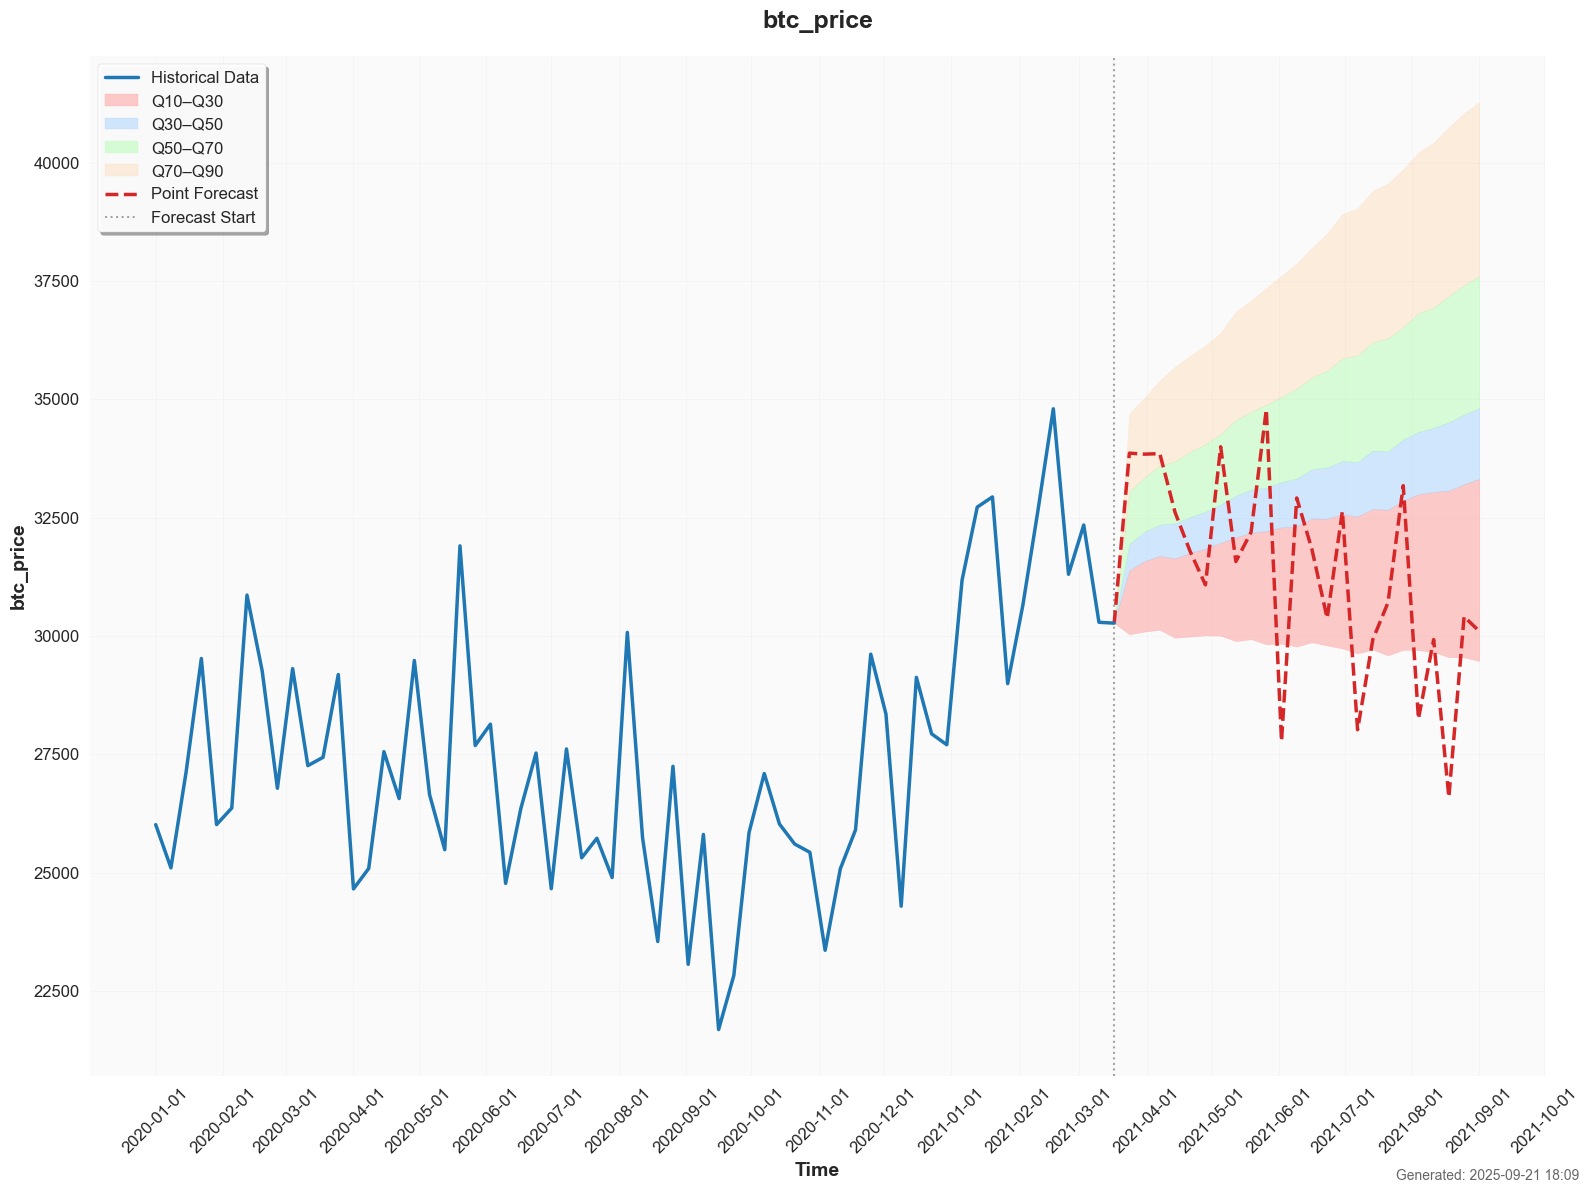

✅ Visualization completed successfully!
   Used quantile intervals: True
   Saved as: ../local/sapheneia_forecast_data_2025-09-21.png


In [13]:
# =============================================================================
# UPDATED VISUALIZATION
# =============================================================================

# Save to file
from datetime import datetime
png_filename = f'../local/sapheneia_forecast_data_{datetime.now().strftime("%Y-%m-%d")}.png'
# png_filename = ... # Your custom filename

if current_results is not None and current_visualizer is not None:
    print("🎨 Creating Visualization ...")
    
    try:
        # Extract visualization data
        viz_data = current_results['visualization_data']
        results = current_results['results']
        
        historical_data = viz_data['historical_data']
        dates_historical = viz_data['dates_historical']
        dates_future = viz_data['dates_future']
        target_name = viz_data['target_name']
        forecast = viz_data['forecast']
        title = viz_data['title']
        
        # Use already processed quantile bands from previous cell
        intervals = {}
        used_quantile_intervals = False
        
        if 'quantile_bands' in results:
            print("   📊 Using pre-processed quantile bands...")
            intervals = results['quantile_bands']
            used_quantile_intervals = len(intervals) > 0
            print(f"   ✅ Using quantile bands: {len(intervals)//3} bands")
            
            # Debug: Print interval keys to verify structure
            print(f"   📊 Interval keys: {list(intervals.keys())}")
            
            # Debug: Print band labels to verify they're correct
            for key in intervals.keys():
                if key.endswith('_label'):
                    print(f"   📊 {key}: {intervals[key]}")
            
        else:
            print("   📊 No pre-processed quantile bands found, processing now...")
            if 'quantile_forecast' in results:
                try:
                    from forecast import process_quantile_bands
                    
                    quantiles = np.array(results['quantile_forecast'])
                    print(f"   📊 Quantile forecast shape: {quantiles.shape}")
                    
                    # Use centralized quantile processing (same as webapp)
                    intervals = process_quantile_bands(
                        quantile_forecast=quantiles,
                        selected_indices=None  # Use default indices (skip index 0)
                    )
                    
                    used_quantile_intervals = len(intervals) > 0
                    print(f"   ✅ Processed quantile bands: {len(intervals)//3} bands")
                    
                except Exception as e:
                    print(f"   ⚠️ Quantile band processing failed: {e}")
                    intervals = {}
                    used_quantile_intervals = False
            else:
                print("   📊 No quantile_forecast found in results")
        
        # Generate plot (same as webapp)
        fig = current_visualizer.plot_forecast_with_intervals(
            historical_data=historical_data,
            forecast=forecast,
            intervals=intervals if intervals else None,
            actual_future=None,  # No actual future data in this demo
            dates_historical=dates_historical,
            dates_future=dates_future,
            title=title,
            target_name=target_name,
            save_path=png_filename
        )
        
        plt.show()
        
        print("✅ Visualization completed successfully!")
        print(f"   Used quantile intervals: {used_quantile_intervals}")
        print(f"   Saved as: {png_filename}")
        
    except Exception as e:
        print(f"❌ Visualization failed: {str(e)}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ Cannot create visualization - missing results or visualizer")


## 9. Data Export

In [14]:
# =============================================================================
# FIXED DATA EXPORT
# =============================================================================

# Save to file
from datetime import datetime
csv_filename = f'../local/sapheneia_forecast_data_{datetime.now().strftime("%Y-%m-%d")}.csv'
# csv_filename = ... # Your custom filename

if current_results is not None and 'results' in current_results:
    print("📁 Exporting Data ...")
    
    try:
        results = current_results['results']
        
        # Debug: Print the structure of the data
        print(f"   📊 Results keys: {list(results.keys())}")
        
        # Get point forecast data and ensure it's flat
        point_forecast_data = None
        if 'point_forecast' in results:
            point_forecast_data = results['point_forecast']
        elif 'enhanced_forecast' in results:
            point_forecast_data = results['enhanced_forecast']
        
        print(f"   📊 Point forecast type: {type(point_forecast_data)}")
        if point_forecast_data is not None:
            print(f"   📊 Point forecast length: {len(point_forecast_data)}")
        else:
            print("   📊 Point forecast length: None")
        
        # Flatten the point forecast if it's nested
        if isinstance(point_forecast_data, (list, np.ndarray)):
            if len(point_forecast_data) > 0 and isinstance(point_forecast_data[0], (list, np.ndarray)):
                print("   📊 Flattening nested point forecast...")
                point_forecast_data = point_forecast_data[0]
        
        forecast_length = len(point_forecast_data) if point_forecast_data is not None else 0
        print(f"   📊 Final forecast length: {forecast_length}")
        
        if forecast_length == 0:
            print("❌ No forecast data available for export")
        else:
            # Create CSV content
            csv_content = 'Period,Point_Forecast'
            
            # Process quantile data
            quantiles_array = None
            num_quantiles = 0
            
            if 'quantile_forecast' in results and isinstance(results['quantile_forecast'], (list, np.ndarray)):
                quantile_forecast = results['quantile_forecast']
                quantiles_array = np.array(quantile_forecast)
                
                print(f"   📊 Quantile forecast shape: {quantiles_array.shape}")
                
                # Handle 3D arrays (1, horizon, quantiles) -> (horizon, quantiles)
                if quantiles_array.ndim == 3:
                    quantiles_array = quantiles_array.squeeze(0)
                    print(f"   📊 After squeeze: {quantiles_array.shape}")
                
                # Ensure shape is (horizon, num_quantiles)
                # Don't transpose - (24, 10) is already correct: 24 time steps, 10 quantiles
                print(f"   📊 Final quantile shape: {quantiles_array.shape}")
                
                num_quantiles = quantiles_array.shape[1]
                # Skip index 0 (legacy mean), add Q10, Q20, Q30, Q40, Q50, Q60, Q70, Q80, Q90
                for i in range(1, num_quantiles):
                    percentile = i * 10  # 1->Q10, 2->Q20, etc.
                    csv_content += f',Q{percentile}'
                
                print(f"   ✅ Added {num_quantiles-1} raw quantile columns (Q10-Q{90})")
            
            csv_content += '\n'
            
            # Add data rows
            for i in range(forecast_length):
                csv_content += f'{i + 1}'
                
                # Point forecast - ensure it's a single value
                point_val = point_forecast_data[i]
                csv_content += f',{point_val}'
                
                # Raw quantiles (skip index 0 - legacy mean)
                if quantiles_array is not None:
                    # Skip index 0, add Q10, Q20, Q30, Q40, Q50, Q60, Q70, Q80, Q90
                    for j in range(1, num_quantiles):
                        csv_content += f',{quantiles_array[i, j]}'
                
                csv_content += '\n'
            
            with open(csv_filename, 'w', encoding='utf-8') as f:
                f.write(csv_content)
            
            print("✅ Data export completed successfully!")
            print(f"   File: {csv_filename}")
            print(f"   Rows: {forecast_length}")
            
            # Fix f-string syntax error by extracting newline
            newline = '\n'
            print(f"   Columns: {len(csv_content.split(newline)[0].split(','))}")
            
            # Display sample of exported data
            print("\n📊 Sample of exported data:")
            sample_df = pd.read_csv(csv_filename)
            print(sample_df.head())
            
    except Exception as e:
        print(f"❌ Data export failed: {str(e)}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ No results available for export")


📁 Exporting Data ...
   📊 Results keys: ['point_forecast', 'method', 'quantile_forecast', 'metadata', 'quantile_bands']
   📊 Point forecast type: <class 'numpy.ndarray'>
   📊 Point forecast length: 1
   📊 Flattening nested point forecast...
   📊 Final forecast length: 24
   📊 Quantile forecast shape: (1, 24, 10)
   📊 After squeeze: (24, 10)
   📊 Final quantile shape: (24, 10)
   ✅ Added 9 raw quantile columns (Q10-Q90)
✅ Data export completed successfully!
   File: ../local/sapheneia_forecast_data_2025-09-21.csv
   Rows: 24
   Columns: 11

📊 Sample of exported data:
   Period  Point_Forecast           Q10           Q20           Q30  \
0       1    33863.553641  28859.875000  30036.281250  30753.673828   
1       2    33842.719554  28902.111328  30093.841797  30913.050781   
2       3    33854.179455  28843.189453  30130.826172  30959.574219   
3       4    32615.324092  28624.125000  29963.111328  30870.921875   
4       5    31782.780193  28526.972656  29988.519531  30949.681641   

